In [1]:
%pylab inline
# %env CUDA_VISIBLE_DEVICES=""

import numpy as np
import pandas as pd
from statsmodels import api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Conv1D, AvgPool1D, Input, Flatten
from keras.layers import LSTM, GRU, SimpleRNN, Bidirectional, Dense, TimeDistributed
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption, calculate_datetime_diffs
from tools import to_timeseries, get_task2
from tools import split_x_y, split_train_test
from tools import vis_evaluate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


# Configuration

In [34]:
SEQUENCE_SIZE = 178
BATCH_SIZE = 512

# Data

In [39]:
def get_task2(y):
    n = y.shape[0]
    data = np.zeros((n, 4))

    for i in range(n):
        data[i] = (y[i, 0, 0], y[i].min(), y[i].max(), y[i].mean())
        
    return data

In [40]:
dataset = load_household_power_consumption(hour_one_hot=True)
dataset['active_power'] = dataset['active_power'].rolling(window=12).mean()
dataset['active_power_mean'] = dataset['active_power'].rolling(window=12).mean()
dataset['active_power_std'] = dataset['active_power'].rolling(window=12).std()
dataset['active_power_diff1'] = dataset['active_power'].diff(-1)
dataset['active_power_diff2'] = dataset['active_power'].diff(-2)
dataset['active_power_diff3'] = dataset['active_power'].diff(-3)
dataset['active_power_diff4'] = dataset['active_power'].diff(-4)
dataset['active_power_diff5'] = dataset['active_power'].diff(-5)

dataset['active_power2'] = dataset['active_power']**2
dataset['active_power3'] = dataset['active_power']**3
dataset['active_power4'] = dataset['active_power']**4
dataset['active_power5'] = dataset['active_power']**5
dataset['active_power6'] = dataset['active_power']**6
dataset['active_power7'] = dataset['active_power']**7
dataset['active_power8'] = dataset['active_power']**8
dataset['active_power9'] = dataset['active_power']**9
dataset = dataset.dropna()

data_x, data_y = split_x_y(dataset, SEQUENCE_SIZE)
diff_x, diff_y = split_x_y(calculate_datetime_diffs(dataset), SEQUENCE_SIZE)

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(
    to_timeseries(data_x, diff_x, t=SEQUENCE_SIZE), 
    to_timeseries(data_y, diff_y, t=SEQUENCE_SIZE), 
    train_ratio=0.8)

train_y2 = get_task2(train_y)
test_y2 =  get_task2(test_y)

# train_y = pad_sequences(train_y.reshape(-1, SEQUENCE_SIZE), maxlen=SEQ_Y_SIZE, truncating='post', dtype='float32')
# test_y = pad_sequences(test_y.reshape(-1, SEQUENCE_SIZE), maxlen=SEQ_Y_SIZE, truncating='post', dtype='float32')
# train_y = pad_sequences(train_y, SEQUENCE_SIZE, padding='post', dtype='float32').reshape(-1, SEQUENCE_SIZE, 1)
# test_y = pad_sequences(test_y, SEQUENCE_SIZE, padding='post', dtype='float32').reshape(-1, SEQUENCE_SIZE, 1)

display(dataset[['active_power', 'reactive_power', 'voltage', 'intensity', 'sub1',
                 'sub2', 'sub3', 'h_0', 'h_1', 'h_23']].head())


print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print()
print('diff_x:', diff_x.shape)
print('diff_y:', diff_y.shape)
print()
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print()
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-29 18:02:31,825 [hybrid-lstm.tool | INFO] Load existing dataset


,active_power,reactive_power,voltage,intensity,sub1,sub2,sub3,h_0,h_1,h_23
datetime,,,,,,,,,,
2010-10-27 14:02:00,0.593667,0.064,247.27,2.6,0.0,0.0,0.0,0,0,0
2010-10-27 14:03:00,0.601167,0.064,247.45,2.6,0.0,0.0,1.0,0,0,0
2010-10-27 14:04:00,0.608500,0.064,247.29,2.6,0.0,0.0,1.0,0,0,0
2010-10-27 14:05:00,0.614333,0.066,247.92,2.6,0.0,0.0,0.0,0,0,0
2010-10-27 14:06:00,0.612167,0.046,247.42,2.6,0.0,0.0,1.0,0,0,0


data_x: (43438, 46)
data_y: (43438, 1)

diff_x: (43438, 1)
diff_y: (43438, 1)

train_x: (33051, 178, 46)
train_y: (33051, 178, 1)

test_x: (8263, 178, 46)
test_y: (8263, 178, 1)


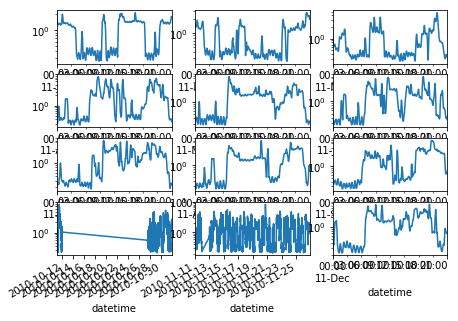

In [41]:
def show_active_power():
    fig, plots = subplots(4, 3)
    plots = plots.reshape(-1)
    fig.set_figheight(5)
    fig.set_figwidth(7)

    for i, p in enumerate(plots):
        i += 1
        dataset['active_power'].loc[f'2010-{i:02}'].plot(logy=True, ax=p)
        
show_active_power()

파란색 그래프가 보이면 안됩니다.
파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거


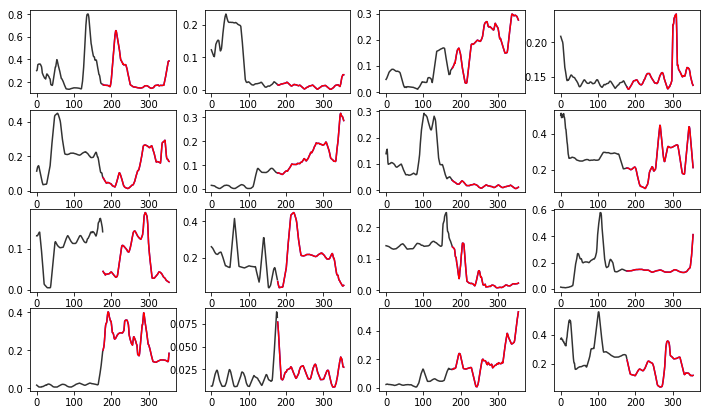

In [42]:
def vis_dataset(x, y):
    n = x.shape[0]
    seq_n = x.shape[1]
    
    fig, plots = pylab.subplots(4, 4)
    fig.set_figwidth(12)
    fig.set_figheight(7)
    plots = plots.reshape(-1)

    for p in plots:
        idx = np.random.randint(0, n-SEQUENCE_SIZE)
        x1 = np.arange(seq_n)
        x2 = np.arange(seq_n, seq_n*2)
        
        p.plot(x1, x[idx, :, 0], label='input', color='#333333')
        p.plot(x2, x[idx+SEQUENCE_SIZE, :, 0], label='output', color='blue')
        p.plot(x2, y[idx, :, 0], label='output', color='red')
        
print('파란색 그래프가 보이면 안됩니다.')
print('파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거')
vis_dataset(train_x, train_y)

# Models

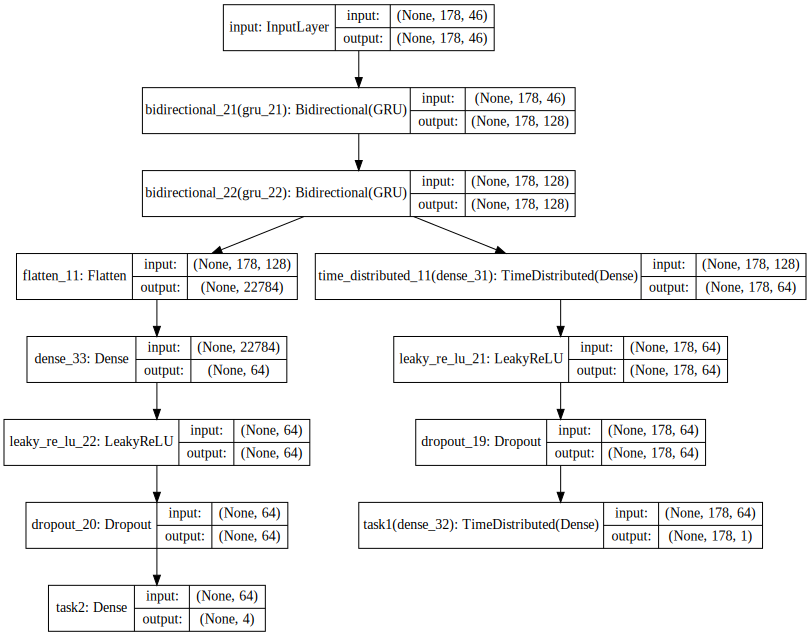

In [43]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_model(l1, l2, d1=64, d2=64, dout1=None, dout2=None, n_input=40):
    np.random.seed(0)
    input = Input(shape=(SEQUENCE_SIZE, n_input), name='input')
    rnn1 = Bidirectional(GRU(l1, return_sequences=True, recurrent_dropout=0.1))(input)
    rnn2 = Bidirectional(GRU(l1, return_sequences=True, recurrent_dropout=0.1))(rnn1)
    
    # Task 1
    h1 = TimeDistributed(Dense(d1))(rnn2)
    h1 = LeakyReLU()(h1)
    if dout1:
        h1 = Dropout(dout1)(h1)
    h1 = TimeDistributed(Dense(1), name='task1')(h1)
    
    # Task 2
    h2 = Flatten()(rnn2)
    h2 = Dense(d2)(h2)
    h2 = LeakyReLU()(h2)
    if dout2:
        h2 = Dropout(dout2)(h2)
    h2 = Dense(4, name='task2')(h2)
    
    model = Model(inputs=[input], outputs=[h1, h2])
    model.compile(optimizer=Adam(clipnorm=1.), 
                  loss={'task1': 'mse', 'task2': 'mse'},
                  loss_weights=[1., 0.3], 
                  metrics=[r2])
    return model

def create_model2(l1=64, l2=64, n_input=31):
    np.random.seed(0)
    model = Sequential()
    model.add(Bidirectional(GRU(l1, return_sequences=True), input_shape=(SEQUENCE_SIZE, n_input)))
    model.add(Bidirectional(GRU(l1, return_sequences=True)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(clipnorm=1.), metrics=[r2])
    return model

model = create_model(64, 64, d1=64, d2=64, dout1=0.2, dout2=0.2, n_input=46)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [44]:
model = create_model(128, 128, d1=128, d2=128, dout1=0.3, dout2=0.3, n_input=46)
history = History()
model.fit(train_x, [train_y, train_y2], epochs=200, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, [test_y, test_y2]), callbacks=[history])

Train on 33051 samples, validate on 8263 samples
Epoch 1/200
34s - loss: 1.2406 - task1_loss: 0.0351 - task2_loss: 4.0183 - task1_r2: -1.6076e+00 - task2_r2: -1.9885e+02 - val_loss: 0.0094 - val_task1_loss: 0.0071 - val_task2_loss: 0.0076 - val_task1_r2: -4.9441e-01 - val_task2_r2: 0.1662
Epoch 2/200
33s - loss: 0.0138 - task1_loss: 0.0105 - task2_loss: 0.0110 - task1_r2: 0.2261 - task2_r2: 0.4683 - val_loss: 0.0088 - val_task1_loss: 0.0070 - val_task2_loss: 0.0058 - val_task1_r2: -4.7947e-01 - val_task2_r2: 0.2993
Epoch 3/200
33s - loss: 0.0125 - task1_loss: 0.0099 - task2_loss: 0.0088 - task1_r2: 0.2700 - task2_r2: 0.5759 - val_loss: 0.0089 - val_task1_loss: 0.0071 - val_task2_loss: 0.0062 - val_task1_r2: -4.1462e-01 - val_task2_r2: 0.2985
Epoch 4/200
33s - loss: 0.0118 - task1_loss: 0.0093 - task2_loss: 0.0083 - task1_r2: 0.3152 - task2_r2: 0.6014 - val_loss: 0.0084 - val_task1_loss: 0.0066 - val_task2_loss: 0.0058 - val_task1_r2: -3.6175e-01 - val_task2_r2: 0.3758
Epoch 5/200
33s -

33s - loss: 0.0014 - task1_loss: 0.0011 - task2_loss: 9.9207e-04 - task1_r2: 0.9186 - task2_r2: 0.9523 - val_loss: 0.0101 - val_task1_loss: 0.0085 - val_task2_loss: 0.0055 - val_task1_r2: -8.6689e-01 - val_task2_r2: 0.2289
Epoch 38/200
33s - loss: 0.0013 - task1_loss: 0.0010 - task2_loss: 9.3288e-04 - task1_r2: 0.9226 - task2_r2: 0.9550 - val_loss: 0.0106 - val_task1_loss: 0.0090 - val_task2_loss: 0.0053 - val_task1_r2: -9.6541e-01 - val_task2_r2: 0.2932
Epoch 39/200
33s - loss: 0.0013 - task1_loss: 0.0010 - task2_loss: 9.1560e-04 - task1_r2: 0.9260 - task2_r2: 0.9558 - val_loss: 0.0106 - val_task1_loss: 0.0088 - val_task2_loss: 0.0059 - val_task1_r2: -9.5904e-01 - val_task2_r2: 0.1510
Epoch 40/200
33s - loss: 0.0013 - task1_loss: 9.8951e-04 - task2_loss: 8.8464e-04 - task1_r2: 0.9268 - task2_r2: 0.9574 - val_loss: 0.0102 - val_task1_loss: 0.0086 - val_task2_loss: 0.0054 - val_task1_r2: -8.3807e-01 - val_task2_r2: 0.3095
Epoch 41/200
33s - loss: 0.0012 - task1_loss: 9.5455e-04 - task2_

33s - loss: 6.6889e-04 - task1_loss: 5.3278e-04 - task2_loss: 4.5370e-04 - task1_r2: 0.9606 - task2_r2: 0.9781 - val_loss: 0.0111 - val_task1_loss: 0.0093 - val_task2_loss: 0.0061 - val_task1_r2: -1.1262e+00 - val_task2_r2: 0.1797
Epoch 72/200
33s - loss: 6.6115e-04 - task1_loss: 5.2776e-04 - task2_loss: 4.4462e-04 - task1_r2: 0.9610 - task2_r2: 0.9786 - val_loss: 0.0104 - val_task1_loss: 0.0087 - val_task2_loss: 0.0057 - val_task1_r2: -8.1423e-01 - val_task2_r2: 0.2289
Epoch 73/200
33s - loss: 6.4592e-04 - task1_loss: 5.1722e-04 - task2_loss: 4.2899e-04 - task1_r2: 0.9618 - task2_r2: 0.9793 - val_loss: 0.0109 - val_task1_loss: 0.0092 - val_task2_loss: 0.0058 - val_task1_r2: -1.1049e+00 - val_task2_r2: 0.2061
Epoch 74/200
33s - loss: 6.4602e-04 - task1_loss: 5.1611e-04 - task2_loss: 4.3303e-04 - task1_r2: 0.9618 - task2_r2: 0.9791 - val_loss: 0.0103 - val_task1_loss: 0.0086 - val_task2_loss: 0.0056 - val_task1_r2: -8.1679e-01 - val_task2_r2: 0.2755
Epoch 75/200
33s - loss: 6.2662e-04 -

33s - loss: 4.3053e-04 - task1_loss: 3.4711e-04 - task2_loss: 2.7807e-04 - task1_r2: 0.9743 - task2_r2: 0.9866 - val_loss: 0.0103 - val_task1_loss: 0.0087 - val_task2_loss: 0.0055 - val_task1_r2: -8.5061e-01 - val_task2_r2: 0.2952
Epoch 106/200
33s - loss: 3.9298e-04 - task1_loss: 3.1552e-04 - task2_loss: 2.5819e-04 - task1_r2: 0.9767 - task2_r2: 0.9876 - val_loss: 0.0100 - val_task1_loss: 0.0084 - val_task2_loss: 0.0055 - val_task1_r2: -8.2801e-01 - val_task2_r2: 0.2862
Epoch 107/200
33s - loss: 4.1404e-04 - task1_loss: 3.3301e-04 - task2_loss: 2.7011e-04 - task1_r2: 0.9754 - task2_r2: 0.9870 - val_loss: 0.0103 - val_task1_loss: 0.0086 - val_task2_loss: 0.0057 - val_task1_r2: -9.3043e-01 - val_task2_r2: 0.2326
Epoch 108/200
33s - loss: 3.8797e-04 - task1_loss: 3.1150e-04 - task2_loss: 2.5492e-04 - task1_r2: 0.9770 - task2_r2: 0.9877 - val_loss: 0.0100 - val_task1_loss: 0.0084 - val_task2_loss: 0.0054 - val_task1_r2: -8.1959e-01 - val_task2_r2: 0.3021
Epoch 109/200
33s - loss: 3.9056e-

33s - loss: 3.1020e-04 - task1_loss: 2.3554e-04 - task2_loss: 2.4888e-04 - task1_r2: 0.9826 - task2_r2: 0.9880 - val_loss: 0.0096 - val_task1_loss: 0.0081 - val_task2_loss: 0.0051 - val_task1_r2: -7.1697e-01 - val_task2_r2: 0.3568
Epoch 140/200
33s - loss: 3.1617e-04 - task1_loss: 2.4017e-04 - task2_loss: 2.5333e-04 - task1_r2: 0.9822 - task2_r2: 0.9878 - val_loss: 0.0096 - val_task1_loss: 0.0081 - val_task2_loss: 0.0051 - val_task1_r2: -7.5720e-01 - val_task2_r2: 0.3495
Epoch 141/200
33s - loss: 3.1284e-04 - task1_loss: 2.3823e-04 - task2_loss: 2.4870e-04 - task1_r2: 0.9824 - task2_r2: 0.9880 - val_loss: 0.0100 - val_task1_loss: 0.0083 - val_task2_loss: 0.0056 - val_task1_r2: -9.0340e-01 - val_task2_r2: 0.2511
Epoch 142/200
33s - loss: 3.2994e-04 - task1_loss: 2.5090e-04 - task2_loss: 2.6347e-04 - task1_r2: 0.9815 - task2_r2: 0.9873 - val_loss: 0.0095 - val_task1_loss: 0.0080 - val_task2_loss: 0.0051 - val_task1_r2: -7.8363e-01 - val_task2_r2: 0.3502
Epoch 143/200
33s - loss: 3.3885e-

33s - loss: 2.7343e-04 - task1_loss: 1.9780e-04 - task2_loss: 2.5213e-04 - task1_r2: 0.9854 - task2_r2: 0.9879 - val_loss: 0.0098 - val_task1_loss: 0.0082 - val_task2_loss: 0.0051 - val_task1_r2: -8.8181e-01 - val_task2_r2: 0.3220
Epoch 174/200
33s - loss: 2.7826e-04 - task1_loss: 2.0045e-04 - task2_loss: 2.5934e-04 - task1_r2: 0.9852 - task2_r2: 0.9875 - val_loss: 0.0095 - val_task1_loss: 0.0080 - val_task2_loss: 0.0050 - val_task1_r2: -7.7052e-01 - val_task2_r2: 0.3659
Epoch 175/200
33s - loss: 2.6019e-04 - task1_loss: 1.8713e-04 - task2_loss: 2.4354e-04 - task1_r2: 0.9862 - task2_r2: 0.9883 - val_loss: 0.0095 - val_task1_loss: 0.0079 - val_task2_loss: 0.0050 - val_task1_r2: -7.4866e-01 - val_task2_r2: 0.3579
Epoch 176/200
33s - loss: 2.7148e-04 - task1_loss: 1.9512e-04 - task2_loss: 2.5452e-04 - task1_r2: 0.9856 - task2_r2: 0.9877 - val_loss: 0.0095 - val_task1_loss: 0.0080 - val_task2_loss: 0.0049 - val_task1_r2: -7.3689e-01 - val_task2_r2: 0.3681
Epoch 177/200
33s - loss: 2.6162e-

In [ ]:
model = create_model(l1=64, l2=64, n_input=46)

history = History()
model.fit(train_x, train_y, epochs=200, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

# Evaluation

In [16]:
%time eval_results = model.evaluate(test_x, [test_y, test_y2], batch_size=BATCH_SIZE, verbose=2)

for k, v in zip(model.metrics_names, eval_results):
    print(f'{k}: {v}')

CPU times: user 1.02 s, sys: 216 ms, total: 1.24 s
Wall time: 1.15 s
loss: 0.00945693154497072
task1_loss: 0.006859986189178898
task2_loss: 0.00865648439588864
task1_r2: 0.3450962363786362
task2_r2: 0.6379645029886516


[3250] r^2: 0.6989      
[7917] r^2: -6.424      
[3525] r^2: -3.204      
[7035] r^2: 0.1012      
[2396] r^2: 0.362       
[7169] r^2: -3.084      
[3965] r^2: -1.577      
[5941] r^2: 0.1591      
[7626] r^2: 0.2041      
[4086] r^2: 0.4294      
[2760] r^2: 0.4841      
[3606] r^2: -0.6293     
[5797] r^2: -20.72      
[4042] r^2: -0.452      
[5726] r^2: -57.32      
[5702] r^2: -48.44      


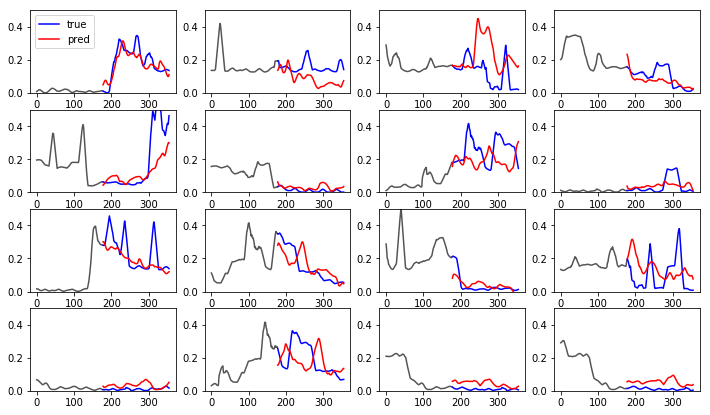

In [48]:
def vis_evaluate(model, test_x, test_y, batch=32):
    n = len(test_x)
    seq_n = test_x.shape[1]

    fig, plots = pylab.subplots(4, 4)
    plots = plots.reshape(-1)

    fig.set_figwidth(12)
    fig.set_figheight(7)

    for i, p in enumerate(plots):
        idx = np.random.randint(0, n)
        input_y = test_x[idx, :, 0]
        x1 = np.arange(seq_n)
        x2 = np.arange(seq_n, seq_n * 2)

        true_y = test_y[idx]
        pred1, pred2 = model.predict(test_x[idx:idx + 1], batch_size=batch)
        p.set_ylim(0, 0.5)
        score = r2_score(true_y.reshape(-1), pred1.reshape(-1))
        print(f'[{idx:<4}] r^2: {score:<12.4}')
        p.plot(x1, input_y, color='#555555')
        p.plot(x2, true_y, color='blue', label='true')
        p.plot(x2, pred1[0], color='red', label='pred')
        if i == 0:
            p.legend()


vis_evaluate(model, test_x, test_y, batch=BATCH_SIZE)